In [99]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [109]:
jackknife_file = '/mnt/store1/oliverphilcox/Mock1QPM4/xi_jack_new/xi_jack_n35_m10_j169_11.dat'
weight_dir = '/mnt/store1/oliverphilcox/Mock1QPM4/weights/'
file_root = '/mnt/store1/oliverphilcox/Mock1QPM4/RascalXi/'
m = 10
n_samples = 20

In [110]:
xi_input="/mnt/store1/oliverphilcox/Mock1QPM4/xi_new/xi_n35_m10_11.dat"
xi_in = np.loadtxt(xi_input,skiprows=2)

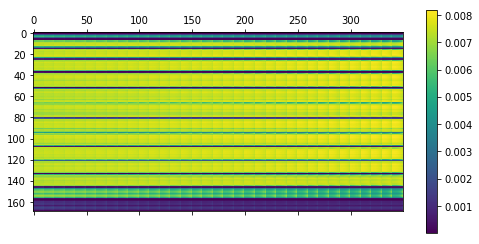

In [111]:
plt.matshow(weights);plt.colorbar();

(-2, 2)

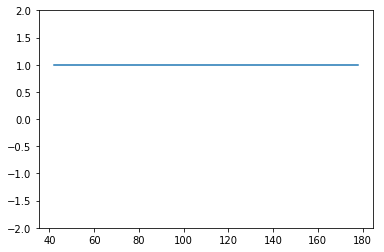

In [112]:
plt.plot(rr,mean_xi.reshape(n,m).mean(axis=1)/xi_in.mean(axis=1))
plt.ylim([-2,2])

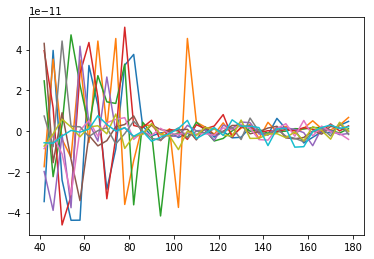

In [113]:
rr=np.arange(42.,182.,4.)
for i in range(10):
    plt.plot(rr,mean_xi.reshape(n,m)[:,i]-xi_in.reshape(n,m)[:,i],ls='-');
#plt.yscale('log')

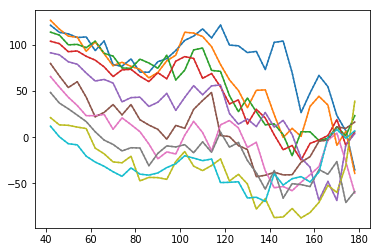

In [114]:
rr=np.arange(42.,182.,4.)
for i in range(10):
    plt.plot(rr,mean_xi.reshape(n,m)[:,i]*rr*rr,ls='-');
for i in range(10):
    plt.plot(rr,xi_in.reshape(n,m)[:,i]*rr*rr,ls=':');
#plt.yscale('log')

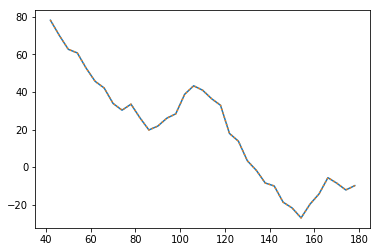

In [115]:
rr=np.arange(42.,182.,4.)
plt.plot(rr,mean_xi.reshape(n,m).mean(axis=1)*rr*rr,ls='-');
plt.plot(rr,xi_in.reshape(n,m)[:,:].mean(axis=1)*rr*rr,ls=':');
#plt.yscale('log')

ValueError: cannot reshape array of size 350 into shape (45,20)

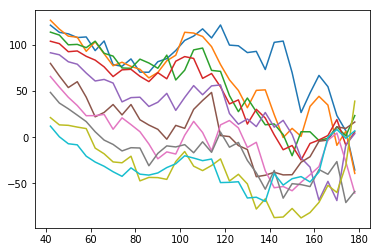

In [116]:
rr=np.arange(42.,182.,4.)
for i in range(10):
    plt.plot(rr,mean_xi.reshape(n,m)[:,i]*rr*rr,ls='-');
for i in range(20):
    plt.plot(rr,xi_in.reshape(n+10,m*2)[10:,i]*rr*rr,ls=':');
#plt.yscale('log')

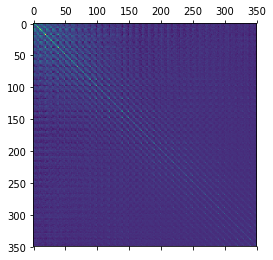

In [36]:
plt.matshow(data_cov)

In [108]:
# Load jackknife xi estimates from data
print("Loading correlation function jackknife estimates from %s"%jackknife_file)
xi_jack = np.loadtxt(jackknife_file,skiprows=2)
n_bins = xi_jack.shape[1] # total bins
n_jack = xi_jack.shape[0] # total jackknives
n = n_bins//m # radial bins

weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

print("Loading weights file from %s"%weight_file)
weights = np.loadtxt(weight_file)[:,1:]

# First exclude any dodgy jackknife regions
good_jk=np.unique(np.where(np.isfinite(xi_jack))[0])
print("Using %d out of %d jackknives"%(len(good_jk),n_jack))
xi_jack = xi_jack[good_jk]
weights = weights[good_jk]

# Compute data covariance matrix
print("Computing data covariance matrix")
mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
tmp = weights*(xi_jack-mean_xi)
data_cov = np.matmul(tmp.T,tmp)
denom = np.matmul(weights.T,weights)
data_cov /= (np.ones_like(denom)-denom)

print("Loading weights file from %s"%RR_file)
RR=np.loadtxt(RR_file)

def load_matrices(index,jack=True):
    """Load intermediate or full covariance matrices"""
    if jack:
        cov_root = file_root+'CovMatricesJack/'
    else:
        cov_root = file_root+'CovMatricesAll/'
    c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))
    c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))
    c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
    if jack:
        EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
        EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))
    
        # Compute disconnected term
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
        diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
        RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
        fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
        cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
        c4+=cx
    
    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

# Load in full jackknife theoretical matrices
print("Loading best estimate of jackknife covariance matrix")
c2,c3,c4=load_matrices('full')

# Load in partial jackknife theoretical matrices
c2s,c3s,c4s=[],[],[]
for i in range(n_samples):
    print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i)
    c2s.append(cc2)
    c3s.append(cc3)
    c4s.append(cc4)

# Compute inverted matrix
def Psi(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    c_tot = c2*alpha**2.+c3*alpha+c4
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

Loading correlation function jackknife estimates from /mnt/store1/oliverphilcox/Mock1QPM4/xi_jack_new/xi_jack_n35_m10_j169_11.dat
Loading weights file from /mnt/store1/oliverphilcox/Mock1QPM4/weights/jackknife_weights_n35_m10_j169_11.dat
Using 169 out of 169 jackknives
Computing data covariance matrix
Loading weights file from /mnt/store1/oliverphilcox/Mock1QPM4/weights/binned_pair_counts_n35_m10_j169_11.dat
Loading best estimate of jackknife covariance matrix
Loading jackknife subsample 1 of 20
Loading jackknife subsample 2 of 20
Loading jackknife subsample 3 of 20
Loading jackknife subsample 4 of 20
Loading jackknife subsample 5 of 20
Loading jackknife subsample 6 of 20
Loading jackknife subsample 7 of 20
Loading jackknife subsample 8 of 20
Loading jackknife subsample 9 of 20
Loading jackknife subsample 10 of 20
Loading jackknife subsample 11 of 20
Loading jackknife subsample 12 of 20
Loading jackknife subsample 13 of 20
Loading jackknife subsample 14 of 20
Loading jackknife subsampl

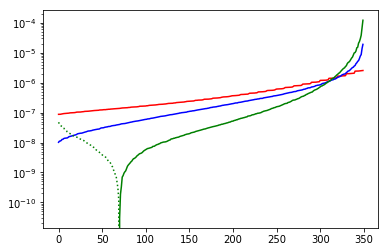

In [220]:
plt.plot(np.linalg.eigvalsh(c2),c='r',label='C2j')
plt.plot(np.linalg.eigvalsh(c3),c='b',label='C3j')
plt.plot(np.linalg.eigvalsh(c4),c='g',label='C4j')
plt.plot(-np.linalg.eigvalsh(c4),c='g',ls=':')
plt.yscale('log')

In [221]:
# Now optimize for shot-noise rescaling parameter alpha
print("Optimizing for the shot-noise rescaling parameter")
from scipy.optimize import fmin
alpha_best = fmin(neg_log_L1,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best)


Optimizing for the shot-noise rescaling parameter
Optimization terminated successfully.
         Current function value: -4529.970012
         Iterations: 11
         Function evaluations: 22
Optimization complete - optimal rescaling parameter is 1.108789


## Compute residuals

In [222]:
#alpha_best = 1.05
# Compute jackknife and full covariance matrices
jack_cov = c4+c3*alpha_best+c2*alpha_best**2.
jack_prec = Psi(alpha_best)
c2f,c3f,c4f=load_matrices('full',jack=False)
full_cov = c4f+c3f*alpha_best+c2f*alpha_best**2.


In [235]:
# Load in partial full theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    print("Loading full subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i,jack=False)
    c2fs.append(cc2)
    c3fs.append(cc3)
    c4fs.append(cc4)

# Compute inverted matrix
def Psi_full(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    cf_tot = c2f*alpha**2.+c3f*alpha+c4f
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2fs[i]+alpha*c3fs[i]+c4fs[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(cf_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi_full(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

Loading full subsample 1 of 20
Loading full subsample 2 of 20
Loading full subsample 3 of 20
Loading full subsample 4 of 20
Loading full subsample 5 of 20
Loading full subsample 6 of 20
Loading full subsample 7 of 20
Loading full subsample 8 of 20
Loading full subsample 9 of 20
Loading full subsample 10 of 20
Loading full subsample 11 of 20
Loading full subsample 12 of 20
Loading full subsample 13 of 20
Loading full subsample 14 of 20
Loading full subsample 15 of 20
Loading full subsample 16 of 20
Loading full subsample 17 of 20
Loading full subsample 18 of 20
Loading full subsample 19 of 20
Loading full subsample 20 of 20


In [236]:
qpm_prec = np.load('/mnt/store1/oliverphilcox/qpm_999_mock_covariance_improved.npz')['prec']
qpm_cov = np.load('/mnt/store1/oliverphilcox/qpm_999_mock_covariance_improved.npz')['cov']

In [237]:
from scipy.optimize import fmin
alpha_best_full = fmin(neg_log_L1_full,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full)


Optimization terminated successfully.
         Current function value: -4447.377672
         Iterations: 10
         Function evaluations: 20
Optimization complete - optimal rescaling parameter is 1.052051


In [228]:
full_prec,n_eff_full = Psi_full(alpha_best_full,return_neff=True)
print("Full n_eff = %.2e"%n_eff_full)

Full n_eff = 2.69e+05


In [188]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM4/radial_binning_cov.csv').mean(axis=1)
mu_bins_tmp = np.linspace(0.,1.,m+1)
mu_bins = np.mean([mu_bins_tmp[1:],mu_bins_tmp[:-1]],axis=0)

n=len(r_bins)
r_bins_all = np.concatenate([[r_bins[i] for _ in range(m)] for i in range(len(r_bins))])
mu_bins_all = np.hstack([mu_bins for _ in range(len(r_bins))])
r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))


#full_prec2 = np.linalg.inv(c2*1.6**2.+c3*4.+c4)
resid = np.divide(full_prec-qpm_prec,r_matrix)
resid_jack_cov = np.multiply(qpm_cov-(c2*alpha_best**2.+c3*alpha_best+c4),r_matrix)

r_diff = []
for rr in r_bins:
    for rr2 in r_bins:
        r_diff.append(rr-rr2)
r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
mu_diff = []
for mu in mu_bins:
    for mu2 in mu_bins:
        mu_diff.append(mu-mu2)
mu_diff = np.unique(np.asarray(mu_diff).round(8)) # remove rounding errors

mu_edge = np.linspace(-1,1,len(mu_diff)+1)

delta_r = r_diff[1]-r_diff[0]
r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)

mu_edges = np.vstack([mu_edge for _ in range(len(r_edge))])
r_edges = np.vstack([r_edge for _ in range(len(mu_edge))])

In [189]:
stacked_resid = np.zeros([len(mu_diff),len(r_diff)])
stacked_resid_jack = np.zeros([len(mu_diff),len(r_diff)])
denom = np.zeros([len(mu_diff),len(r_diff)])
for i in range(len(resid)):
    for j in range(resid.shape[1]):
        r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
        mu_index = np.where((mu_bins_all[i]-mu_bins_all[j]).round(4)==mu_diff.round(4))
        stacked_resid[mu_index,r_index]=resid[i,j]
        stacked_resid_jack[mu_index,r_index]=resid_jack_cov[i,j]
        denom[mu_index,r_index]+=1
stacked_resid/=denom
stacked_resid_jack/=denom

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


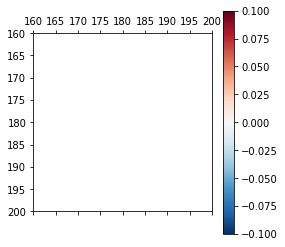

In [193]:
matrix = data_cov-c2*alpha_best**2.-c3*alpha_best-c4
vmax=np.max(matrix.ravel())
plt.matshow(matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.ylim([200,160])
plt.xlim([160,200])
plt.colorbar()

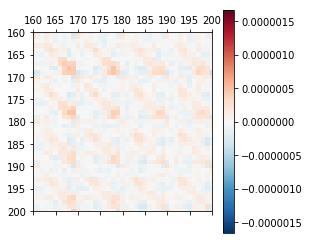

In [191]:
#matrix = qpm_cov-c2f*1.6**2.-c3f*4.-c4f
matrix = qpm_cov-c2f*alpha_best_full**2.-c3f*alpha_best_full-c4f
vmax=np.max(matrix.ravel())
plt.matshow(matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.ylim([200,160])
plt.xlim([160,200])
plt.colorbar()

In [71]:
def neg_log_L1_flex(par):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    alpha,beta,gamma=par
    theory_jack = np.linalg.inv(c2*alpha**2.+c3*beta+c4*gamma)
    logdet = np.linalg.slogdet(theory_jack)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(theory_jack,data_cov))-logdet[1]

In [72]:
fmin(neg_log_L1_flex,[1.,1.,1.])

Optimization terminated successfully.
         Current function value: -4530.043075
         Iterations: 54
         Function evaluations: 98


array([1.10950526, 1.18511858, 0.94698774])

In [73]:
def neg_log_L1_flex_full(par):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    alpha,beta,gamma=par
    theory_full = np.linalg.inv(c2f*alpha**2.+c3f*beta+c4f*gamma)
    logdet = np.linalg.slogdet(theory_full)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(theory_full,qpm_cov))-logdet[1]

In [74]:
fmin(neg_log_L1_flex_full,[1.,1.,1.])

Optimization terminated successfully.
         Current function value: -4455.614719
         Iterations: 53
         Function evaluations: 97


array([1.024345  , 1.19587811, 0.9761829 ])

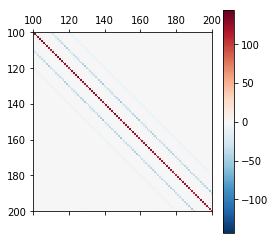

In [75]:
matrix = np.divide(full_prec,r_matrix)
vmax=np.max(matrix.ravel())
plt.matshow(matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.ylim([200,100])
plt.xlim([100,200])
plt.colorbar()

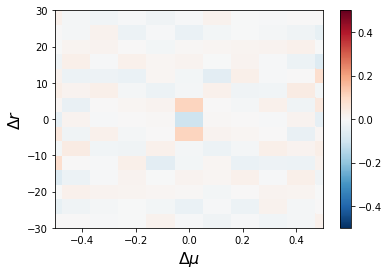

In [76]:
vmax=0.5
plt.pcolor(mu_edges.T,r_edges,stacked_resid,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
plt.ylim([-30,30]);
plt.xlim([-0.5,0.5])
plt.colorbar();FS=16
plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);

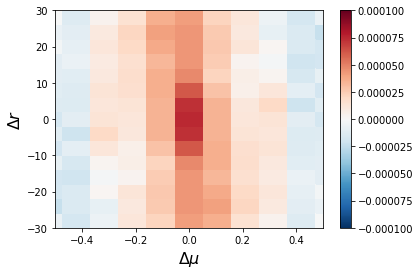

In [77]:
vmax=0.0001
plt.pcolor(mu_edges.T,r_edges,stacked_resid_jack,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
plt.ylim([-30,30]);
plt.xlim([-0.5,0.5])
plt.colorbar();FS=16
plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);

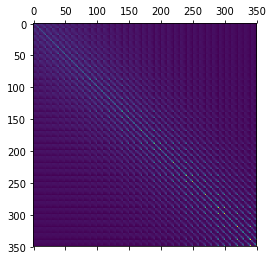

In [78]:
plt.matshow(np.multiply(jack_cov,r_matrix))

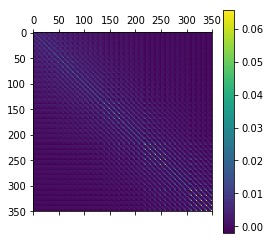

In [79]:
plt.matshow(np.multiply(c2+c3+c4,r_matrix))
plt.colorbar()

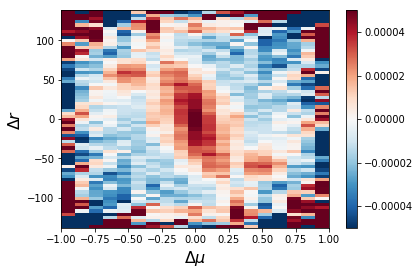

In [80]:
vmax=0.00005
plt.pcolor(mu_edges.T,r_edges,stacked_resid_jack,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
#plt.ylim([-30,30]);
#plt.xlim([-0.5,0.5])
plt.colorbar();FS=16
plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);

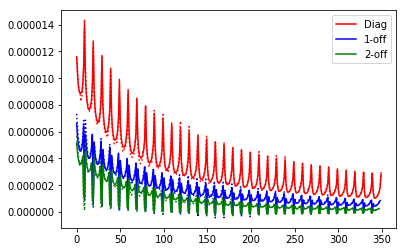

In [81]:
alph=alpha_best
c_full = c2f*alph**2.+c3f*alph+c4f
diag,diag1,diag2=[],[],[]
qdiag,qdiag1,qdiag2=[],[],[]
for i in range(len(c_full)):
    diag.append(c_full[i,i])
    qdiag.append(qpm_cov[i,i])
    if i<len(c_full)-1:
        diag1.append(c_full[i,i+1])
        qdiag1.append(qpm_cov[i,i+1])
    if i<len(c_full)-2:
        diag2.append(c_full[i,i+2])
        qdiag2.append(qpm_cov[i,i+2])
plt.plot(diag,label='Diag',c='r')
plt.plot(qdiag,c='r',ls=':')

plt.plot(diag1,label='1-off',c='b')
plt.plot(qdiag1,c='b',ls=':')

plt.plot(diag2,label='2-off',c='g')
plt.plot(qdiag2,c='g',ls=':')
plt.legend()
#plt.yscale('log')

(0.2, 2)

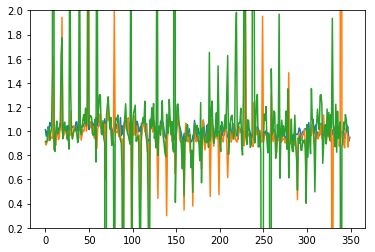

In [82]:
plt.plot(np.asarray(diag)/np.asarray(qdiag))
plt.plot(np.asarray(diag1)/np.asarray(qdiag1))
plt.plot(np.asarray(diag2)/np.asarray(qdiag2))
plt.ylim([0.2,2])

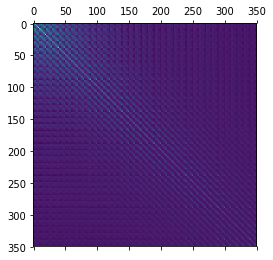

In [83]:
plt.matshow(qpm_cov)

Check RR counts for consistency

In [259]:
RR_est=np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM4/RascalXi/CovMatricesAll/RR_n35_m10_11_full.txt')
RR_cf = np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM4/weights/binned_pair_counts_n35_m10_j169_11.dat')

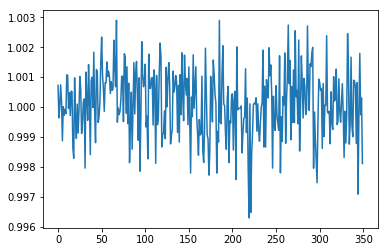

In [260]:
plt.plot(RR_est/RR_cf*10**2.)

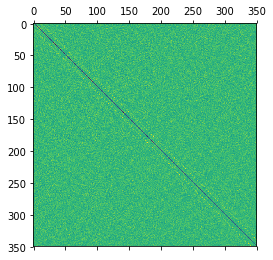

In [86]:
plt.matshow(resid)

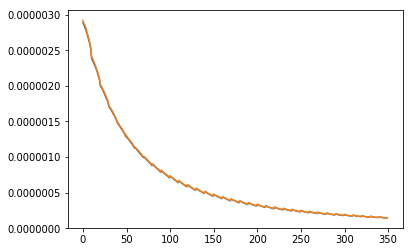

In [253]:
#plt.plot(np.diag(data['c4'])[100:])
#plt.plot(np.diag(c4f))
#plt.plot(np.diag(data['c3'])[100:])
#plt.plot(np.diag(c3f))
plt.plot(np.diag(data['c2'])[100:])
plt.plot(np.diag(c2f))

In [239]:
from scipy.linalg import sqrtm

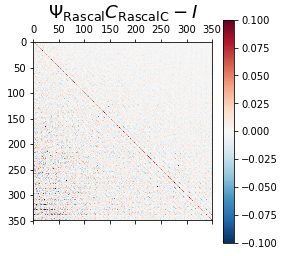

In [252]:
c2r=data['c2'][100:,100:]
c3r=data['c3'][100:,100:]
c4r=data['c4'][100:,100:]
cr=c2r+c3r+c4r
cf=c2f+c3f+c4f
precr=np.linalg.inv(cr)
chol = np.linalg.cholesky(precr)
disc=np.matmul(chol,np.matmul(cf,chol.T))-np.eye(len(precr))
disc = np.matmul(precr,cf)-np.eye(len(precr))

plt.matshow(disc,vmax=.1,vmin=-.1,cmap=cm.RdBu_r);
plt.title(r"$^{\Psi_\mathrm{Rascal}C_\mathrm{RascalC}-I}$",fontsize=26)
plt.colorbar()

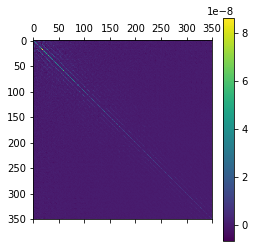

In [241]:
plt.matshow(c3f-c3r);plt.colorbar();

In [250]:
c2+c3+c4

array([[ 8.77291500e-06,  5.12360800e-06,  3.99097600e-06, ...,
        -1.04446678e-07, -1.34531706e-07, -1.74978365e-07],
       [ 5.12360800e-06,  7.70117300e-06,  4.35991350e-06, ...,
        -1.04522278e-07, -1.38242526e-07, -1.80144399e-07],
       [ 3.99097600e-06,  4.35991350e-06,  7.14172400e-06, ...,
        -1.01960195e-07, -1.39439855e-07, -1.77673554e-07],
       ...,
       [-1.04446678e-07, -1.04522278e-07, -1.01960195e-07, ...,
         8.70926400e-07,  4.03857770e-07,  1.41850962e-07],
       [-1.34531706e-07, -1.38242526e-07, -1.39439855e-07, ...,
         4.03857770e-07,  1.15489460e-06,  5.40191655e-07],
       [-1.74978365e-07, -1.80144399e-07, -1.77673554e-07, ...,
         1.41850962e-07,  5.40191655e-07,  2.08063200e-06]])

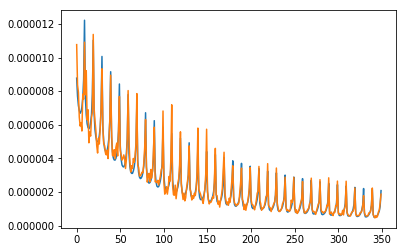

In [251]:
plt.plot(np.diag(c2+c3+c4))
plt.plot(np.diag(data_cov))

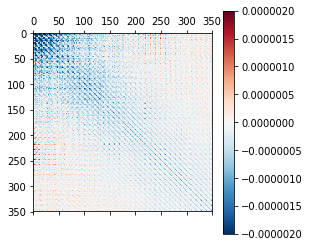

In [249]:
plt.matshow(data_cov-qpm_cov,cmap=cm.RdBu_r,vmax=0.000002,vmin=-0.000002);plt.colorbar()

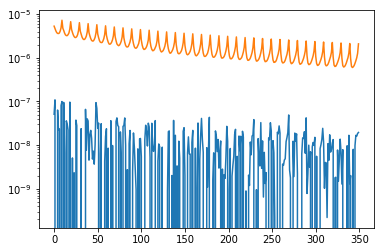

In [114]:
plt.plot(np.diag(c4f-c4r))
plt.plot(np.diag(c4f))
plt.yscale('log')

In [87]:
import pickle
data=pickle.load(open("/mnt/store1/oliverphilcox/LowR__mean.pkl","rb"),encoding='latin1')

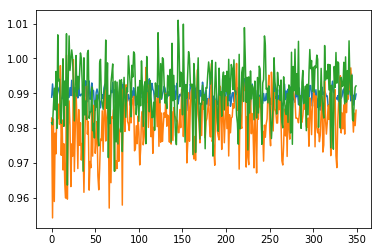

In [245]:
plt.plot(np.diag(data['c2'])[100:]/np.diag(c2f))
plt.plot(np.diag(data['c3'])[100:]/np.diag(c3f))
plt.plot(np.diag(data['c4'])[100:]/np.diag(c4f))
#plt.plot(np.diag(c4f))
#plt.yscale('log')

In [89]:
def l1_test(alpha):
    c_full = data['c2'][100:,100:]*alpha**2.+data['c3'][100:,100:]+data['c4'][100:,100:]
    prec=np.linalg.inv(c_full)
    logdet = np.linalg.slogdet(c_full)
    if logdet[0]<0:
        return np.inf
    else:
        return np.trace(np.matmul(qpm_cov,prec))+logdet[1]

In [90]:
fmin(l1_test,1.)

Optimization terminated successfully.
         Current function value: -4453.642380
         Iterations: 11
         Function evaluations: 22


array([1.07519531])

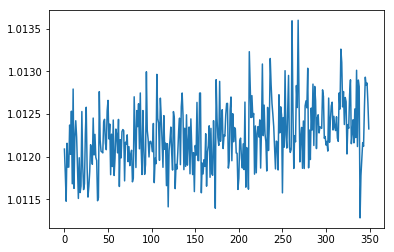

In [246]:
plt.plot(data['Ra'][100:]/RR_cf*100.)
#plt.plot(RR_cf/100.)

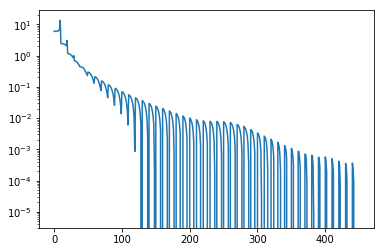

In [247]:
plt.plot(data['cx'])
plt.yscale('log')

In [248]:
data

{'r_center': array([  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,  10.,  10.,
         10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  14.,  14.,  14.,
         14.,  14.,  14.,  14.,  14.,  14.,  14.,  18.,  18.,  18.,  18.,
         18.,  18.,  18.,  18.,  18.,  18.,  22.,  22.,  22.,  22.,  22.,
         22.,  22.,  22.,  22.,  22.,  26.,  26.,  26.,  26.,  26.,  26.,
         26.,  26.,  26.,  26.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
         30.,  30.,  30.,  34.,  34.,  34.,  34.,  34.,  34.,  34.,  34.,
         34.,  34.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,
         38.,  42.,  42.,  42.,  42.,  42.,  42.,  42.,  42.,  42.,  42.,
         46.,  46.,  46.,  46.,  46.,  46.,  46.,  46.,  46.,  46.,  50.,
         50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  54.,  54.,
         54.,  54.,  54.,  54.,  54.,  54.,  54.,  54.,  58.,  58.,  58.,
         58.,  58.,  58., 

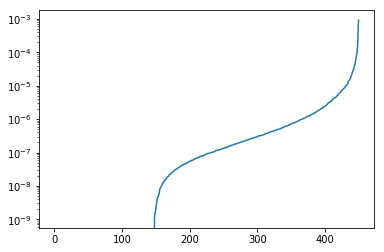

In [54]:
plt.plot(np.linalg.eigvalsh(data['c4']))
plt.yscale('log')

In [616]:
data.keys()

dict_keys(['r_center', 'mu_center', 'rmins', 'mumins', 'survey_opts', 'NSamp', 'corr_opts', 'Ra', 'RASCAL_version', 'cx', 'descriptive_keys', 'c3', 'c2', 'repeats', 'c4'])

In [378]:
jack_prec,n_eff_jack=Psi(1.7,return_neff=True)

In [379]:
print(n_eff_jack)

2393847.25491299


## Look at rescaling with full model vs mocks

In [361]:
## basic version
def full_prec(alpha):
    c_tot = c2f*alpha**2.+c3f*alpha+c4f
    return np.linalg.inv(c_tot)

def KL_full_likelihood(alpha):
    this_prec = full_prec(alpha)
    slogdet = np.linalg.slogdet(this_prec)
    if slogdet[0]<0:
        return np.inf
    return np.trace(np.matmul(this_prec,qpm_cov))-slogdet[1]

In [362]:
from scipy.optimize import fmin
fmin(KL_full_likelihood,1.)

Optimization terminated successfully.
         Current function value: -4452.199609
         Iterations: 15
         Function evaluations: 30


array([1.61054688])

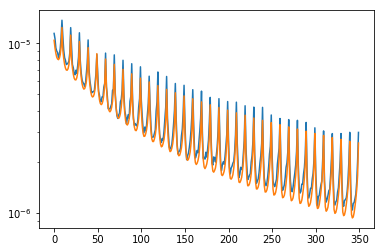

In [364]:
this_alpha=1.61
plt.plot(np.diag(qpm_cov))
plt.plot(np.diag(this_alpha**2.*c2f+this_alpha*c3f+c4f))
plt.yscale('log')

In [365]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM4/radial_binning_cov.csv').mean(axis=1)
mu_bins_tmp = np.linspace(0.,1.,m+1)
mu_bins = np.mean([mu_bins_tmp[1:],mu_bins_tmp[:-1]],axis=0)

n=len(r_bins)
r_bins_all = np.concatenate([[r_bins[i] for _ in range(m)] for i in range(len(r_bins))])
mu_bins_all = np.hstack([mu_bins for _ in range(len(r_bins))])
r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))

qpm_cov = np.load('/mnt/store1/oliverphilcox/qpm_999_mock_covariance.npz')['cov']
resid = np.divide(full_prec(this_alpha)-np.linalg.inv(qpm_cov),r_matrix)

r_diff = []
for rr in r_bins:
    for rr2 in r_bins:
        r_diff.append(rr-rr2)
r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
mu_diff = []
for mu in mu_bins:
    for mu2 in mu_bins:
        mu_diff.append(mu-mu2)
mu_diff = np.unique(np.asarray(mu_diff).round(8)) # remove rounding errors

mu_edge = np.linspace(-1,1,len(mu_diff)+1)

delta_r = r_diff[1]-r_diff[0]
r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)

mu_edges = np.vstack([mu_edge for _ in range(len(r_edge))])
r_edges = np.vstack([r_edge for _ in range(len(mu_edge))])

In [366]:
stacked_resid = np.zeros([len(mu_diff),len(r_diff)])
denom = np.zeros([len(mu_diff),len(r_diff)])
for i in range(len(resid)):
    for j in range(resid.shape[1]):
        r_index = np.where(r_bins_all[i]-r_bins_all[j]==r_diff)
        mu_index = np.where((mu_bins_all[i]-mu_bins_all[j]).round(4)==mu_diff.round(4))
        stacked_resid[mu_index,r_index]=resid[i,j]
        denom[mu_index,r_index]+=1
stacked_resid/=denom

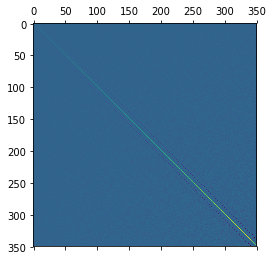

In [367]:
plt.matshow(np.linalg.inv(qpm_cov))

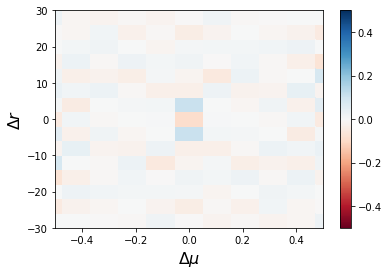

In [377]:
vmax=0.5
plt.pcolor(mu_edges.T,r_edges,stacked_resid,cmap=cm.RdBu,vmax=vmax,vmin=-vmax)
plt.ylim([-30,30]);
plt.xlim([-0.5,0.5])
plt.colorbar();FS=16
plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);

## Plot covariances

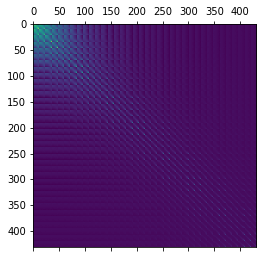

In [119]:
plt.matshow(c4)

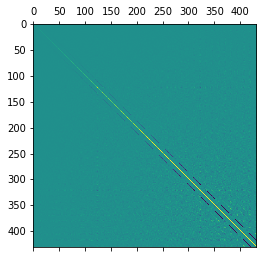

In [120]:
mat=np.linalg.inv(c2+alpha_best*c3+alpha_best**2.*c4)
vmax = np.percentile(mat,99.9)
plt.matshow(mat,vmax=vmax,vmin=-vmax);
#plt.ylim([144,72])
#plt.xlim([72,144]);

In [121]:
xi=np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM3/xi/xi_n200_m120_11.dat',skiprows=2)
xi_r = np.genfromtxt('/mnt/store1/oliverphilcox/Mock1QPM3/xi/xi_n200_m120_11.dat',max_rows=1)

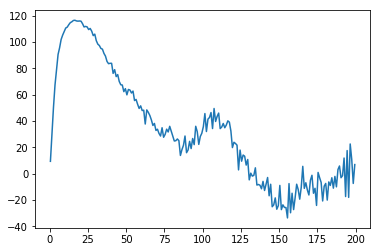

In [122]:
plt.plot(xi_r,xi_r**2.*xi.mean(axis=1))

## Look at eigenvalues

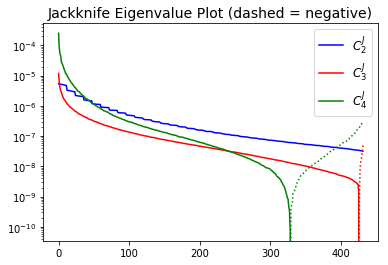

In [123]:
eig4 = np.linalg.eigvalsh(c4)
eig3 = np.linalg.eigvalsh(c3)
eig2 = np.linalg.eigvalsh(c2)
plt.plot(eig2[::-1],label=r'$C^J_2$',c='b')
plt.plot(eig3[::-1],label=r'$C^J_3$',c='r')
plt.plot(eig4[::-1],label=r'$C^J_4$',c='g')
plt.plot(-eig4[::-1],c='g',ls=':')
plt.plot(-eig3[::-1],c='r',ls=':')
plt.legend(fontsize=12)
plt.yscale('log')
plt.title('Jackknife Eigenvalue Plot (dashed = negative)',fontsize=14);

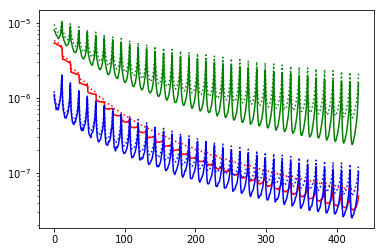

In [130]:
plt.plot(np.diag(c2),c='r',ls='-')
plt.plot(np.diag(c3),c='b',ls='-')
plt.plot(np.diag(c4),c='g',ls='-')
plt.plot(np.diag(c2f),c='r',ls=':')
plt.plot(np.diag(c3f),c='b',ls=':')
plt.plot(np.diag(c4f),c='g',ls=':')
plt.yscale('log')

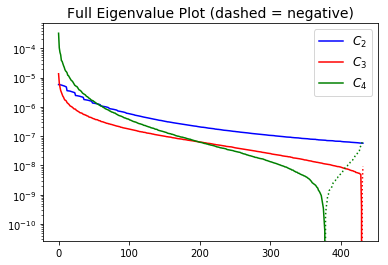

In [124]:
eig4 = np.linalg.eigvalsh(c4f)
eig3 = np.linalg.eigvalsh(c3f)
eig2 = np.linalg.eigvalsh(c2f)
plt.plot(eig2[::-1],label=r'$C_2$',c='b')
plt.plot(eig3[::-1],label=r'$C_3$',c='r')
plt.plot(eig4[::-1],label=r'$C_4$',c='g')
plt.plot(-eig4[::-1],c='g',ls=':')
plt.plot(-eig3[::-1],c='r',ls=':')
plt.legend(fontsize=12)
plt.yscale('log')
plt.title('Full Eigenvalue Plot (dashed = negative)',fontsize=14);

In [ ]:
# Compute full precision matrix
print("Computing the full precision matrix estimate:")
# Load in partial jackknife theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    print("Loading full subsample %d of %d"%(i+1,n_samples))
    c2,c3,c4=load_matrices(i,jack=False)
    c2fs.append(c2)
    c3fs.append(c3)
    c4fs.append(c4)
partial_cov=[]
for i in range(n_samples):
    partial_cov.append(alpha_best**2.*c2fs[i]+alpha_best*c3fs[i]+c4fs[i])
tmp=0.
for i in range(n_samples):
    c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
    tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
full_D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
full_prec = np.matmul(np.eye(n_bins)-full_D_est,np.linalg.inv(full_cov))
print("Full precision matrix estimate computed")    

In [154]:
# Now compute effective N:
slogdetD=np.linalg.slogdet(full_D_est)
D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
if slogdetD[0]<0:
    print('help')
N_eff_D = (n_bins+1.)/D_value+1.
print("Total N_eff Estimate: %.4e"%N_eff_D)        

Computing the full precision matrix estimate:
Loading full subsample 1 of 10
Loading full subsample 2 of 10
Loading full subsample 3 of 10
Loading full subsample 4 of 10
Loading full subsample 5 of 10
Loading full subsample 6 of 10
Loading full subsample 7 of 10
Loading full subsample 8 of 10
Loading full subsample 9 of 10
Loading full subsample 10 of 10
Full precision matrix estimate computed
help
Total N_eff Estimate: -5.5693e+02


In [179]:
E = c2+c3+c4
F = c3+2.*c2
invE = np.linalg.inv(E)
invG = -1.*np.matmul(invE,np.matmul(F,invE))

Psi_approx = lambda beta: invE+beta*invG

In [180]:
def L_biased(alpha):
    beta = alpha-1.
    this_Psi = Psi_approx(beta)#Psi_approx(beta)
    slogdet = np.linalg.slogdet(this_Psi)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,this_Psi))-slogdet[1]

In [181]:
from scipy.optimize import fmin
fmin(L_biased,1.)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
Optimization terminated successfully.
         Current function value: -40643.743505
         Iterations: 28
         Function evaluations: 56


array([1.09599543])

In [182]:
def L_biased2(alpha):
    this_cov = (c2*alpha**2.+c3*alpha+c4)
    slogdet = np.linalg.slogdet(this_cov)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,np.linalg.inv(this_cov)))+slogdet[1]

In [183]:
from scipy.optimize import fmin

fmin(L_biased2,1.0)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
Optimization terminated successfully.
         Current function value: -3279402672877255.000000
         Iterations: 72
         Function evaluations: 146


array([0.95033508])

In [117]:
def L_biased3(alpha):
    this_prec = Psi(alpha)
    slogdet = np.linalg.slogdet(this_prec)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,this_prec))-slogdet[1]

In [118]:
from scipy.optimize import fmin
fmin(L_biased3,1.0)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No i

array([0.98652124])

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!


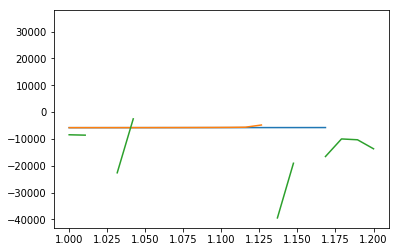

In [120]:
alphas = np.linspace(1,1.2,20)
vals = [L_biased(a) for a in alphas]
plt.plot(alphas,vals,label='1')
vals = [L_biased2(a) for a in alphas]
plt.plot(alphas,vals,label='2')
vals = [L_biased3(a) for a in alphas]
plt.plot(alphas,vals,label='3')

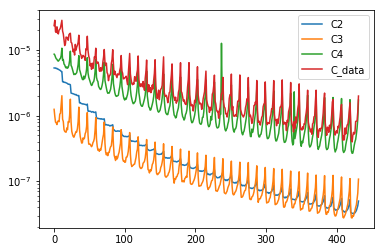

In [450]:
plt.plot(np.diag(c2),label='C2')
plt.plot(np.diag(c3),label='C3')
plt.plot(np.diag(c4),label='C4')
plt.plot(np.diag(data_cov),label='C_data')
plt.yscale('log')
plt.legend();

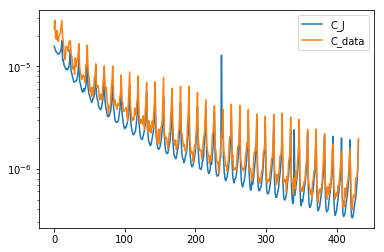

In [453]:
plt.plot(np.diag(c4+alpha_best*c3+alpha_best**2.*c2),label='C_J')
plt.plot(np.diag(data_cov),label='C_data')
plt.yscale('log');plt.legend();

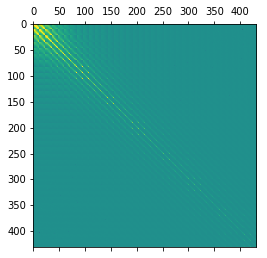

In [452]:
mat=c3
vmax = np.percentile(mat,99.9)
plt.matshow(mat,vmax=vmax,vmin=-vmax);
#plt.ylim([144,72])
#plt.xlim([72,144]);

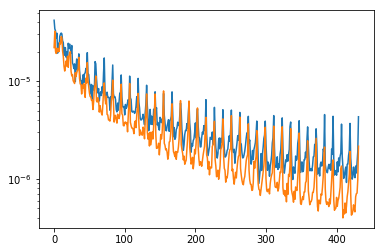

In [141]:
alpha=1.
qpm_cov = np.load('/mnt/store1/oliverphilcox/Mock1QPM2/98QPMCovariance.npy')
#plt.plot(np.diag(alpha**2*c2+alpha*c3+c4));
plt.plot(np.diag(qpm_cov),label='QPM')
plt.plot(np.diag(data_cov),label='Data Jackknife')
#plt.plot(np.diag(qpm_cov))
plt.yscale('log')

## Stacked Residual Plot

In [142]:
alpha_star = 1

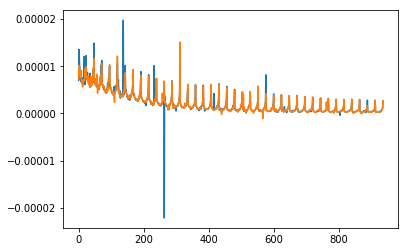

In [52]:
plt.plot(np.diag(c4s[5]))
plt.plot(np.diag(c4s[4]))

In [34]:
def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

In [21]:
def simple_L1(alpha):
    cov = c2*alpha**2.+c3*alpha+c4
    inv_cov = np.linalg.inv(cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        return np.inf
    return np.trace(np.matmul(inv_cov,data_cov))+logdet[1]

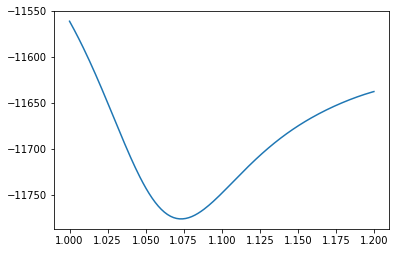

In [28]:
alphas = np.linspace(1,1.2,200)
plt.plot(alphas,[simple_L1(a) for a in alphas])

In [36]:
from scipy.optimize import minimize
out=minimize(neg_log_L1,1.)

In [37]:
out

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.])

In [14]:
out.x

array([1.23699697])

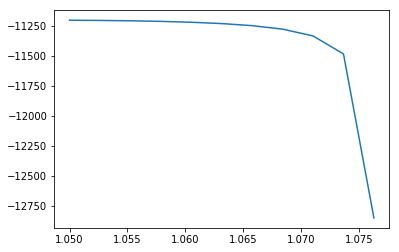

In [105]:
plt.plot(alphas,L1s)

In [86]:
c2ex,c3ex,c4ex=[],[],[]
for i in range(n_samples):
    c2ex.append(np.mean(c2s[:i]+c2s[i+1:],axis=0))
    c3ex.append(np.mean(c3s[:i]+c3s[i+1:],axis=0))
    c4ex.append(np.mean(c4s[:i]+c4s[i+1:],axis=0))

In [96]:
iden = np.eye(len(c2))
def minimizer(alpha):
    
    raise Exception("This is only dPsi/dalpha")
    c_tot = c2*alpha**2.+c3*alpha+c4
    inv_c_tot = np.linalg.inv(c_tot)
    grad_c_tot = 2.*c2*alpha+c3
    tmp_D=0.
    tmp_D_deriv=0.
    for i in range(n_samples):
        this_c = c2s[i]*alpha**2.+c3s[i]*alpha+c4s[i]
        c_excl = c2ex[i]*alpha**2.+c3ex[i]*alpha+c4ex[i]
        inv_c_excl = np.linalg.inv(c_excl)
        grad_this_c = 2.*c2s[i]*alpha+c3s[i]
        grad_c_excl = 2.*c2ex[i]*alpha+c3ex[i]
        tmp_D+=np.matmul(inv_c_excl,this_c)
        tmp = np.matmul(grad_c_excl,np.matmul(inv_c_excl,this_c))
        tmp_D_deriv+=np.matmul(inv_c_excl,grad_this_c-tmp)
    D = (n_samples-1.)/n_samples*(tmp_D/n_samples-iden)
    term1 = np.matmul(iden-D,np.matmul(inv_c_tot,np.matmul(grad_c_tot,inv_c_tot)))
    term2 = (n_samples-1.)/n_samples**2.*tmp_D_deriv
    return np.trace(term1+term2)

In [97]:
iden = np.eye(len(c2))
def minimizer_approx(alpha):
    c_tot = c2*alpha**2.+c3*alpha+c4
    inv_c_tot = np.linalg.inv(c_tot)
    grad_c_tot = 2.*c2*alpha+c3
    fact2 = iden - np.matmul(grad_c_tot,inv_c_tot)
    matrix = np.matmul(data_cov,np.matmul(inv_c_tot,fact2))
    return np.trace(matrix)

In [ ]:
from scipy.optimize

In [98]:
brentq(minimizer_approx,0.5,2.)

1.6394536025721826

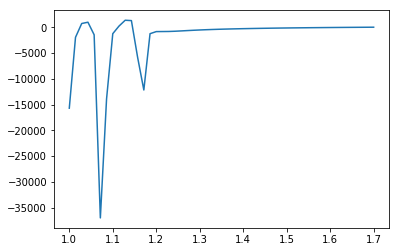

In [101]:
alphas = np.linspace(1.,1.7,50)
mins = [minimizer_approx(a) for a in alphas]
plt.plot(alphas,mins)

In [91]:
from scipy.optimize import brentq

In [94]:
alphas = np.linspace(0.5,2.,10)
funs = [minimizer(a) for a in alphas]

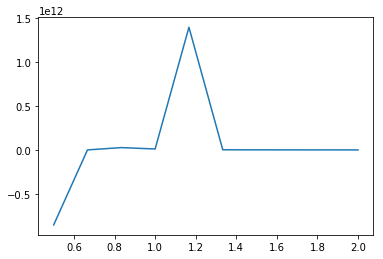

In [95]:
plt.plot(alphas,funs)

In [92]:
brentq(minimizer,0.5,2)

0.8890017401605148

In [71]:
fmin(neg_log_L1,1.76)

Optimization terminated successfully.
         Current function value: -11254.047610
         Iterations: 12
         Function evaluations: 24


array([1.6919375])

In [72]:
from scipy.optimize import brentq

def fn_to_solve(alpha):
    c_tot = c4+alpha*c3+alpha**2.*c2
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-c_tot,np.matmul(c_tot,np.matmul(tmp,c_tot)))
    return np.trace(tmp2)

def fn_to_solve2(alpha):
    prec=Psi(alpha)
    inv_prec = np.linalg.inv(prec)
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-inv_prec,np.matmul(inv_prec,np.matmul(tmp,inv_prec)))
    return np.trace(tmp2)

In [73]:
brentq(fn_to_solve,0,3)

1.7100398051529564

In [74]:
brentq(fn_to_solve2,0,3)

0.06674536661444672

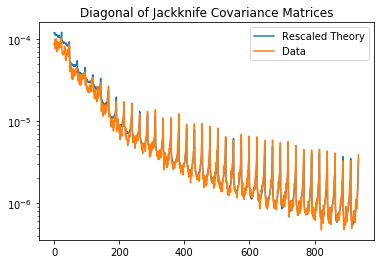

In [112]:
alpha_best=1.8
c_theory = alpha_best**2.*c2+alpha_best*c3+c4
plt.plot(np.diag(c_theory),label='Rescaled Theory')
plt.plot(np.diag(data_cov),label='Data')
plt.yscale('log');plt.title('Diagonal of Jackknife Covariance Matrices')
plt.legend();

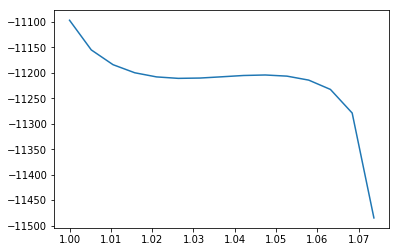

In [109]:
alphas = np.linspace(1.0,1.1,20)
funs = [neg_log_L1(a) for a in alphas]
plt.plot(alphas,funs)

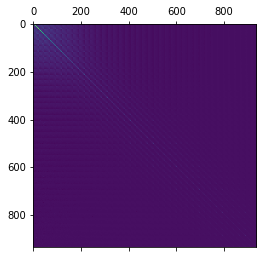

In [110]:
plt.matshow(c_theory)

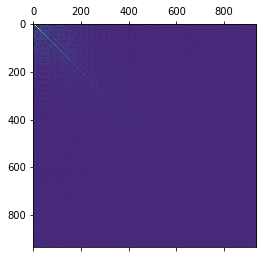

In [111]:
plt.matshow(data_cov)

## Test output

In [1]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

Populating the interactive namespace from numpy and matplotlib


In [3]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

def whiten(mat):
    diag = np.asmatrix(np.diag(mat))
    return mat/np.sqrt(np.matmul(diag.T,diag))

cov=data.f.full_theory_covariance
prec=data.f.full_theory_precision
data_cov = data.f.jackknife_data_covariance
D = data.f.full_theory_D_matrix
ind_cov = data.f.individual_theory_covariances

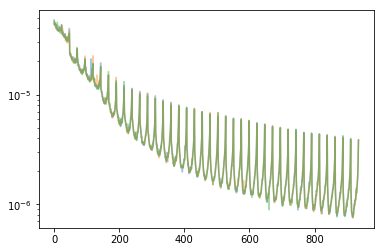

In [13]:
for i in range(3):
    plt.plot(np.diag(ind_cov[i]),alpha=0.4)
plt.yscale('log')

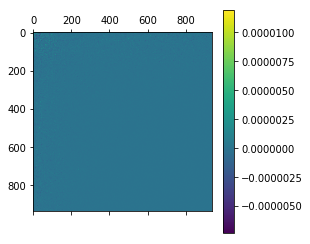

In [14]:
plt.matshow(ind_cov[10]-ind_cov[7]);plt.colorbar()

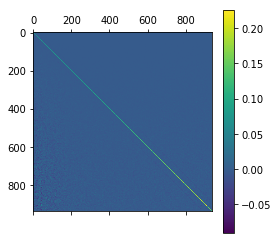

In [5]:
plt.matshow(D);plt.colorbar();

In [59]:
len(D)/np.exp(np.linalg.slogdet(D)[1]/len(D))

10774.426249388594

(360, 240)

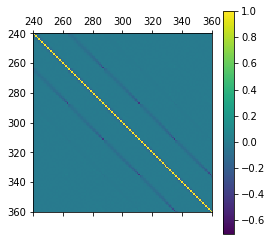

In [36]:
plt.matshow(whiten(prec));plt.colorbar()
plt.xlim([240,360]);plt.ylim([360,240])

In [32]:
data.f.N_eff

array(-588646.91918145)

## Check RR consistency

In [117]:
N_g = 642051
N_r = 6420510

In [118]:
RR_rascal = np.loadtxt('../../mock1/RR_n39_m24_11_full.txt')

In [119]:
RR_corrfunc=np.loadtxt('../../mock1/binned_pair_counts_n39_m24_j169_11.dat')*(float(N_g)/float(N_r))**2.

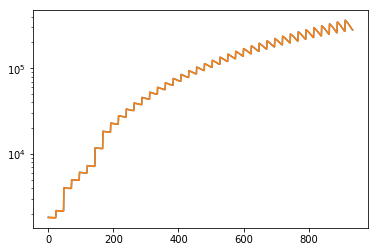

In [120]:
plt.plot(RR_corrfunc)
plt.plot(RR_rascal)
plt.yscale('log')

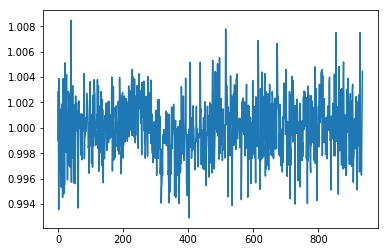

In [121]:
plt.plot(RR_rascal/RR_corrfunc)